# This notebook

## LOOK INTO. 
- Using more or less data.
    - Adding categorical data, removing nan data
- K-fold validation.
- Different activation functions.
- Combine some data for better training:
    - longiture/lattitude combined to distance from centre?
    - Combine stories/floor for a "penthouse" trait.
- one hot encoding for categorical data.
- alternative for filling in nan: mean doesnt work if 90% is nan, and the rest is 1 (balcony)
    - One idea: use a model to predict the value based on other data!
    - Simple idea: drop the features with too much nan (>30%)

# Import

In [2]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
# Specific tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Helper functions

In [3]:
%run utils.py
fractionOfData = 1

# Load data

## Metadata

In [4]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')

In [5]:
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'

In [6]:
metaData = pd.concat([metaData_apartment, metaData_building])

## Train data

In [7]:
train_apartment = pd.read_csv('../data/apartments_train.csv')

In [8]:
train_building = pd.read_csv('../data/buildings_train.csv')

In [9]:
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [10]:
# Reduce amount of data for performance reasons during implementation.
train = train.head(int(train.shape[0] * fractionOfData))
train.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


## Test data

In [11]:
test_apartment = pd.read_csv('../data/apartments_test.csv')

In [12]:
test_building = pd.read_csv('../data/buildings_test.csv')

In [13]:
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test.tail()

,apartment_id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9932,33150,NaN,29.0,NaN,NaN,5.0,1.0,NaN,2.64,0.0,...,6,2014.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
9933,33153,NaN,87.0,12.0,NaN,6.0,3.0,NaN,2.50,0.0,...,105к2,NaN,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9934,33163,NaN,58.1,12.0,30.0,14.0,2.0,1.0,2.70,0.0,...,12,2016.0,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9935,33208,1.0,54.7,5.5,36.9,2.0,3.0,NaN,2.64,1.0,...,10К2,1963.0,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0
9936,33221,1.0,71.5,7.0,49.0,2.0,3.0,NaN,NaN,NaN,...,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


### The nan problem. Some of the data is too shallow for deep learning.

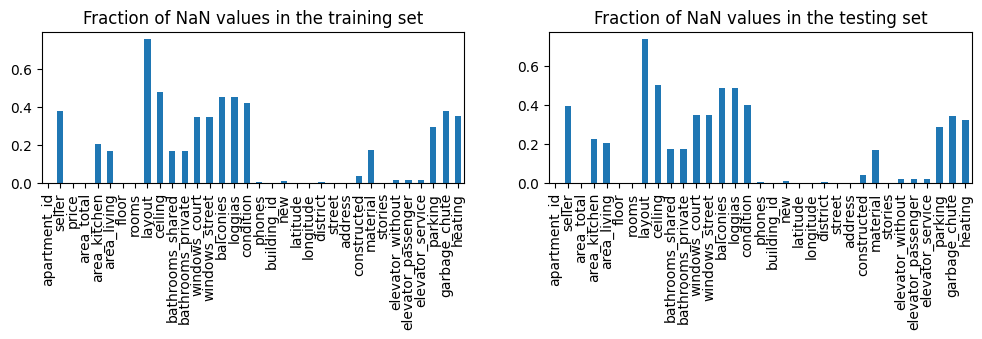

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 2), ncols=2, dpi=100)
train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

## 1 - Expanding on the numerical data
Using longitude and lattitude better.

23197
23285


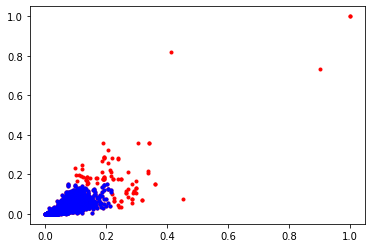

In [71]:
# Remove outlayers
outliers_value = 7
some_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", "price"]

normalized_train = train[some_features]
normalized_train = (normalized_train-normalized_train.min())/(normalized_train.max()-normalized_train.min())


no_outlayers = normalized_train[(np.abs(stats.zscore(normalized_train[["area_total", "price"]])) < outliers_value).all(axis=1)]

#no_outlayers = normalized_train[(np.abs(stats.zscore(normalized_train['price'])) < outliers_value))]
print(len(no_outlayers))
print(len(normalized_train))


plt.plot(normalized_train['area_total'], normalized_train['price'], 'r.')
plt.plot(no_outlayers['area_total'], no_outlayers['price'], 'b.')
#plt.xscale("log")
#plt.yscale("log")
plt.show()


In [16]:
# All numerical features
numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]

# Training
# Labels and targets
labels1 = no_outlayers[numerical_features]
labels1 = labels1.fillna(labels1.mean())
targets1= no_outlayers['price'] # Non nan values here.

# Test
test1 = test[numerical_features]
test1 = test1.fillna(test1.mean())

# Normalize
normalized_labels1 = (labels1-labels1.min())/(labels1.max()-labels1.min())
normalized_test1 = (test1-test1.min())/(test1.max()-test1.min())

In [17]:
# Using distance from centrum istead of latitude/longitude
labels1_normed_r = normalized_labels1.copy()
labels1_normed_r['r'] =  np.sqrt(labels1_normed_r['latitude']**2 + labels1_normed_r['longitude']**2)


## 2 - Adding categorical data
Concern: not enough data to be able to utilize

In [17]:
# Remove outlayers
no_outlayers = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]

In [20]:
# All numerical features
numerical_features = ["area_total", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]

# Training
# Labels and targets
labels2 = no_outlayers[numerical_features]
labels2 = labels2.fillna(labels2.mean())
targets2= no_outlayers['price'] # Non nan values here.

# Test
test2 = test[numerical_features]
test2 = test2.fillna(test2.mean())

# Normalize
normalized_labels2 = (labels2-labels2.min())/(labels2.max()-labels2.min())
normalized_test2 = (test2-test2.min())/(test2.max()-test2.min())

In [21]:
# All categorical features
cat_features = ["seller", "layout", "condition", "district", "material", "parking", "heating"]


